In [1]:
capitalGainsTaxRate = 0.278186
yearlyInflation = 0.02

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def import_monthly_returns() -> np.ndarray:
    df = pd.read_excel('historyIndex.xls', skiprows=6)
    levels = df.iloc[:,1].dropna().map(lambda x: x.replace(',', '')).to_numpy().astype(float)
    monthly_returns = levels[1:] / levels[:-1]
    return monthly_returns

In [5]:
def adjust_mean_return(monthly_returns: np.ndarray, mean_yearly_return: float) -> np.ndarray:
    desired_mean_monthly_return = mean_yearly_return ** (1/12)
    
    num_monthly_returns = monthly_returns.size
    current_mean_monthly_return = monthly_returns.prod() ** (1/num_monthly_returns)
    
    return monthly_returns * desired_mean_monthly_return / current_mean_monthly_return

In [6]:
# Calculate historic average monthly and yearly return
monthly_returns = import_monthly_returns()
# monthly_returns = adjust_mean_return(monthly_returns, 1.05)

num_monthly_returns = monthly_returns.size
mean_monthly_return = monthly_returns.prod() ** (1/num_monthly_returns)
print("Geom. mean monthly return:", "{:.2f}%".format((mean_monthly_return-1)*100))
print("Geom. mean yearly return:", "{:.2f}%".format((mean_monthly_return ** 12 - 1)*100))

Geom. mean monthly return: 0.53%
Geom. mean yearly return: 6.56%


In [7]:
def simulate(monthlyReturns, currentInvest, currentSave, monthlyInvest, monthlySave,
             numYears, numSimulations, capitalGainsTaxRate, yearlyInflation):
    monthlyReturns = np.random.choice(monthlyReturns, size=(numSimulations, 12*numYears))
    totalReturns = monthlyReturns.cumprod(axis=1)
    #print("totalReturns:\n", totalReturns.shape, "\n", totalReturns)
    
    invested = np.full((1, totalReturns.shape[1]), monthlyInvest)
    invested[:, 0] += currentInvest
    invested = invested.cumsum(axis=1)
    #print("invested:\n", invested.shape, "\n", invested)
    
    saved = np.full((1, totalReturns.shape[1]), monthlySave)
    saved[:, 0] += currentSave
    saved = saved.cumsum(axis=1)
    #print("saved:\n", saved.shape, "\n", saved)

    earned = invested + saved
    simulationsAfterTax = totalReturns * invested + saved
    simulationsAfterTax = (simulationsAfterTax - earned) * (0.7 * (1 - capitalGainsTaxRate) + 0.3) + earned
    #print("earned:\n", earned.shape, "\n", earned)
    #print("simulationsAfterTax:\n", simulationsAfterTax.shape, "\n", simulationsAfterTax)
    
    monthlyFactorInflation = (1 - yearlyInflation) ** (1 / 12)
    simulationsAfterTaxAndInflation = simulationsAfterTax * monthlyFactorInflation ** np.arange(numYears * 12)
    
    earnedAfterInflation = earned * monthlyFactorInflation ** np.arange(numYears * 12)
    
    return simulationsAfterTax, earnedAfterInflation

In [8]:
def print_info(currentInvest, currentSave, monthlyInvest, monthlySave, numYears, numSimulations):
    print("Currently invested:", currentInvest)
    print("Currently risk free deposited:", currentSave)
    print("Monthly invested:", monthlyInvest)
    print("Monthly risk free deposited:", monthlySave)
    print("Investment horizon:", numYears, "years")
    print("Number of simulations:", numSimulations)

In [10]:
def print_histogram(outcomes, totalEarned):
    fig, ax = plt.subplots()
    ax.hist(outcomes, bins='auto')
    ax.set_title("Histogram of investment outcomes")
    ax.set_ylabel("Amount of observations")
    ax.set_xlabel("Resulting wealth")
    ax.vlines(x=totalEarned, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='r')
    display(ax)

In [11]:
def print_statistics(outcomes, totalEarned, percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]):
    df = pd.DataFrame(outcomes)
    pd.options.display.float_format = '{:,.2f}'.format
    quantiles = df.quantile(percentiles)
    quantiles.index.name = "Percentiles"
    quantiles.columns = ["Resulting Wealth"]
    display(quantiles)
    
    print("Average resulting wealth", "{:.0f}".format(outcomes.mean()))
    print("Total earned money:", totalEarned)
    
    fractionWorseOutcomes = outcomes[outcomes < totalEarned].size / outcomes.size
    print("Fraction of Worse Outcomes compared to not investing:", fractionWorseOutcomes)

In [12]:
def print_chart(simulation, earned):
    assert simulation.size == earned.size
    fig, ax = plt.subplots()
    xValues = np.arange(1, simulation.size+1)
    ax.plot(xValues, simulation.flatten(), label="simulation")
    ax.plot(xValues, earned.flatten(), label="no investment")
    ax.set_xlabel("time in months")
    ax.set_ylabel("balance")
    ax.set_title("Single simulation")
    ax.legend();
    display(ax)

<Axes: title={'center': 'Single simulation'}, xlabel='time in months', ylabel='balance'>

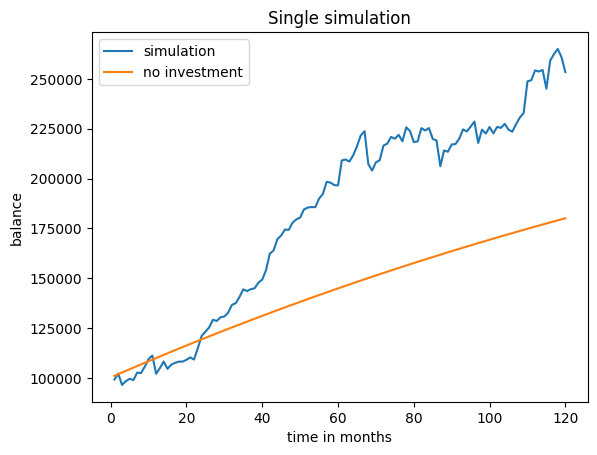

In [62]:
currentInvest = 10000
currentSave = 0
monthlyInvest = 500
monthlySave = 500
numYears = 10

monthlyReturns = import_monthly_returns()
simulation, earned = simulate(monthlyReturns, currentInvest, currentSave, monthlyInvest, monthlySave, numYears, 1, capitalGainsTaxRate, yearlyInflation)
print_chart(simulation, earned)

Currently invested: 33000
Currently risk free deposited: 0
Monthly invested: 1000
Monthly risk free deposited: 0
Investment horizon: 20 years
Number of simulations: 200000


<Axes: title={'center': 'Histogram of investment outcomes'}, xlabel='Resulting wealth', ylabel='Amount of observations'>

,Resulting Wealth
Percentiles,
0.01,"216,013.61"
0.10,"385,404.80"
0.25,"554,553.40"
0.50,"841,915.74"
0.75,"1,284,971.98"
0.90,"1,885,878.07"
0.99,"3,636,693.23"


Average resulting wealth 1028459
Total earned money: 273000
Fraction of Worse Outcomes compared to not investing: 0.02964


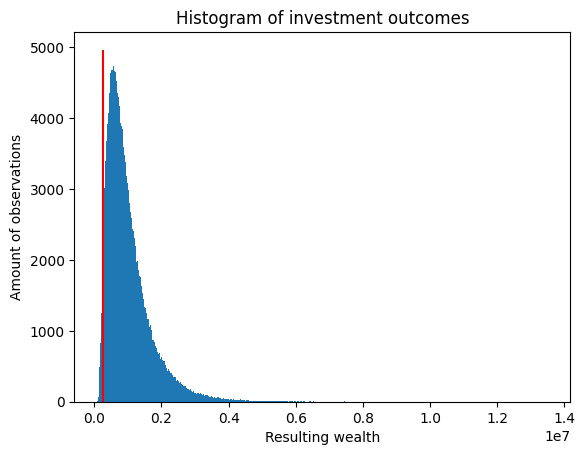

In [43]:
currentInvest = 10_000
currentSave = 0
monthlyInvest = 1_000
monthlySave = 0
numYears = 20
numSimulations = 200000

monthlyReturns = import_monthly_returns()
simulations, _ = simulate(monthlyReturns, currentInvest, currentSave, monthlyInvest, monthlySave, numYears, numSimulations, capitalGainsTaxRate, yearlyInflation)

totalEarned = currentInvest + currentSave + 12*numYears*(monthlyInvest + monthlySave)

outcomes = simulations[:, -1]
print_info(currentInvest, currentSave, monthlyInvest, monthlySave, numYears, numSimulations)
print_histogram(outcomes, totalEarned)
print_statistics(outcomes, totalEarned)